# Understanding Harmonic Structures Through Instantaneous Frequency

In this tutorial, we will explore a seemingly basic question: in analysing oscillatory waveforms, **what is a harmonic?** We will start with explaining nonsinusoidal shapes in terms of harmonics. Then we will define instantaneous frequency and use it think about when two oscillations may be considered independent as opposed to being harmonics. We will use this intuition to formally define harmonic structures and explore the consequences. Spoiler: we will find rich structures and even a connection to the Riemann Zeta function!

This tutorial accompanies the following paper: *Fabus et al. (2022) - Understanding Harmonic Structures Through Instantaneous Frequency*. For a more mathematical exposition of the topic and more details, please refer to that paper (insert DOI). 

Let's start by importing necessary Python modules:

In [2]:
import emd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

plt.rcParams['figure.dpi'] = 100

## Harmonics and nonsinusoidal signals

If you've ever heard of the term 'harmonic', your current definition probably aligns well with that taken from Wikipedia: *A harmonic is a wave with a frequency that is a positive integer multiple of the frequency of the original wave, known as the fundamental frequency*. Harmonics are important across disciplines. We see them in Physics when solving partial differential equations, in Music when considering chords, and even in Neuroscience when we observe nonsinusoidal oscillations [[1]](https://doi.org/10.1016/j.tics.2016.12.008).

It is the last case that we wish to elaborate. The first important concept is that **nonsinusoidal waveforms have harmonics in their spectra**. 

Let's see this in action. We create a 10Hz square wave and look at its Fourier spectrum.

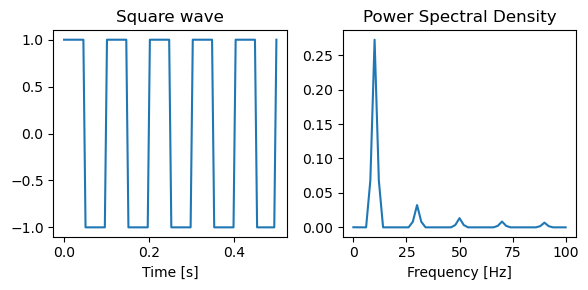

In [3]:
# Sampling rate and time
fs = 200
t = np.linspace(0, 0.5, int(0.5*fs))

# Square wave signal
sig = np.sin(2*np.pi*10*t)
square_wave = signal.square(2*np.pi*10*t, duty=(sig+1)/2)

# Welch's Periodogram
f, pxx = signal.welch(square_wave, fs=fs, nperseg=100)

# Plot
plt.figure(figsize=(6, 3))
plt.subplot(121)
plt.plot(t, square_wave)
plt.title('Square wave')
plt.xlabel('Time [s]')

plt.subplot(122)
plt.plot(f, pxx)
plt.title('Power Spectral Density')
plt.xlabel('Frequency [Hz]')
plt.tight_layout()

We can see the dominant 10Hz peak in the spectrum as well as harmonic peaks at 30Hz, 50Hz, etc. They appear at integer frequency ratios and are sometimes also referred to as 3:1 coupling, 5:1 coupling, etc. Identifying harmonics in datasets is important. Their presence can lead to misleading connectivity results [[2]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7896041/). Moreover, changes in waveform shape (that is equivalently changes in the behaviour of harmonics) have been shown to have functional and clinical significance [[1]](https://doi.org/10.1016/j.tics.2016.12.008). So is it as simple as looking for signals at integer frequency multiples of your main peak?

Unfortunately not. In the plots below we show three waveforms, all of which are a combination of a 10Hz and a 20Hz signal. Only the one on the left is a single, sensible nonsinusoidal oscillation despite this! The other two have large secondary extrema, making it more appropriate to say they are composed of multiple separate oscillations.

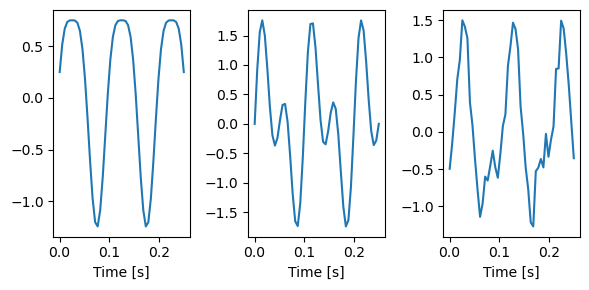

In [5]:
# Sampling rate and time
fs = 200
N = int(0.25*fs)
t = np.linspace(0, 0.25, N)

# Signals
x1 = np.sin(2*np.pi*10*t) + 0.25*np.sin(2*np.pi*20*t+np.pi/2)
x2 = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*20*t)
x3 = np.sin(2*np.pi*10*t) + 0.5*np.sin(2*np.pi*20*t + np.random.uniform(np.pi, 1.5*np.pi, size=N))

# Plot
plt.figure(figsize=(6, 3))
plt.subplot(131)
plt.plot(t, x1)
plt.xlabel('Time [s]')

plt.subplot(132)
plt.plot(t, x2)
plt.xlabel('Time [s]')

plt.subplot(133)
plt.plot(t, x3)
plt.xlabel('Time [s]')

plt.tight_layout()

The difference between these plots is the amplitude ratios of the slow and fast signals and changes in their phase relationship. In order to properly understand what harmonics are and when they appear in our data, we will have to think a bit more about such cases. To help us, we now need to introduce the concept of *instantaneous frequency*.

## Instantaneous Frequency

(For more information on this topic, check out tutorials on the [emd module website](https://emd.readthedocs.io/en/stable/), especially *Waveform shape & Instantaneous Frequency*.)

Apart from the raw signal and its spectrum, there is yet another equivalent way of looking at nonsinusoidal shapes, and that is through their Instantaneous Frequency (IF) trace. Let's calculate it for the left waveform above using the Hilbert transform and see what it looks like.

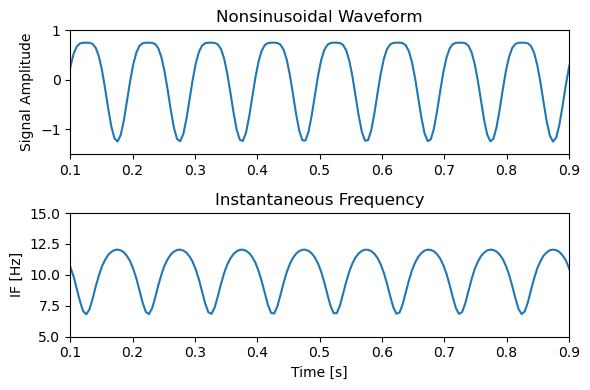

In [6]:
# Prepare longer version of the signal to ignore edge effects
N = int(1*fs)
t = np.linspace(0, 1, N)
x1 = np.sin(2*np.pi*10*t) + 0.25*np.sin(2*np.pi*20*t+np.pi/2)

# Compute the instantaneous frequency
IP, IF, IA = emd.spectra.frequency_transform(x1, fs, 'hilbert')

# Plot
plt.figure(figsize=(6, 4))
plt.subplot(211)
plt.plot(t, x1)
plt.xlim(0.1, 0.9)
plt.ylim(-1.5, 1)
plt.ylabel('Signal Amplitude')
plt.title('Nonsinusoidal Waveform')

plt.subplot(212)
plt.plot(t, IF)
plt.xlabel('Time [s]')
plt.xlim(0.1, 0.9)
plt.ylim(5, 15)
plt.ylabel('IF [Hz]')
plt.title('Instantaneous Frequency')

plt.tight_layout()

We can see the sharp troughs have lower instantaneous frequency and the wide peaks have slower instantaneous frequency. We can think of IF as how quickly the cycle is progressing at different cycle phases. As such it fully captures changes in waveform shape for nonsinusoidal oscillations.

Now let's look at the IF traces for the other two cases from above.

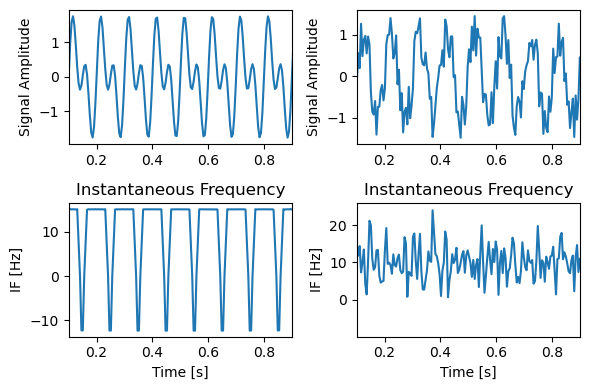

In [7]:
# Prepare longer version of the signal to ignore edge effects
N = int(1*fs)
t = np.linspace(0, 1, N)
x2 = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*20*t)
x3 = np.sin(2*np.pi*10*t) + 0.5*np.sin(2*np.pi*20*t + np.random.uniform(0, 2*np.pi, size=N))
data = [x2, x3]

# Compute the instantaneous frequency and plot
fig, axs = plt.subplots(2, 2, figsize=(6, 4))

for i, x in enumerate(data):
    IP, IF, IA = emd.spectra.frequency_transform(x, fs, 'hilbert')
    ax = axs[0][i]
    ax2 = axs[1][i]
    ax.plot(t, x)
    ax.set_xlim(0.1, 0.9)
    ax.set_ylabel('Signal Amplitude')
    
    ax2.plot(t, IF)
    ax2.set_xlim(0.1, 0.9)
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('IF [Hz]')
    ax2.set_title('Instantaneous Frequency')

plt.tight_layout()

Interesting! We can see that cases where the combination of two oscillations results does not result in a well-formed harmonic structure (that is, secondary extrema are present or the waveform does not repeat from cycle to cycle), the instantaneous frequency informs us this is the case. When large secondary extrema are present, instantaneous frequency has negative values and is thus not well-defined (what would a negative frequency oscillation even mean?). When a constant phase relationship is not present, IF also jitters all over the place, potentially going negative. 

Before we use the above intuitions to formalise what a harmonic is, have a play with the interactive IF simulation below. Try adjusting the Nonlinearity parameter to change the IF range. Notice how secondary extrema appear when IF crosses into negative values. As a bonus, notice this still holds true even when the oscillation experiences slow amplitude modulation, as is often the case for neurophysiological data. You can adjust the AM frequency with the AM_freq slider.

In [3]:
def plot(Nonlinearity, AM_freq):
    k = Nonlinearity; a_f = AM_freq
    t = np.linspace(0, 10, 500)
    IF = 2*np.pi*(1+k*np.cos(2*np.pi*t))
    a = 0.5*(1 + np.sin(a_f*2*np.pi*t))
    y = a * np.cos(2*np.pi*(t + k/(2*np.pi) * np.sin(2*np.pi*t)))

    fig, (ax2, ax1) = plt.subplots(2, 1, figsize=(6, 4))
    ax1.plot(t, IF)
    ax1.plot(t, [0 for _ in t], color='grey')
    
    if np.any(IF<0):
        ax1.scatter(t[IF<0], IF[IF<0], color='red', s=5)
    ax1.set_ylabel('IF [Hz]')
    ax1.set_ylim(-7, 19)
    ax1.set_yticks([-5, 0, 5, 10, 15])
    ax1.set_xlabel('Time [s]')
    
    ax2.plot(t, y)
    ax2.plot(t, a, color='gray')
    ax2.set_ylabel('Signal Amplitude')
    plt.tight_layout()    
    
interact(plot, Nonlinearity=widgets.FloatSlider(min=0, max=2, step=0.2, value=0.6), 
         AM_freq=widgets.FloatSlider(min=0, max=0.3, step=0.05, value=0.05))

interactive(children=(FloatSlider(value=0.6, description='Nonlinearity', max=2.0, step=0.2), FloatSlider(value…

<function __main__.plot(Nonlinearity, AM_freq)>

Finally, you can play with our [shape generator](http://shapegen.herokuapp.com/) to construct any crazy waveform you want and explore its instantaneous frequency. For more information on using the shape generator, see Instructions on its website.

## Formal Harmonic Conditions

Now that we've seen how instantaneous frequency can distinguish between ambiguous cases of summed signals, let's use it to formally define what harmonics are. We shall say that a resultant signal $x(t)$ formed as a sum of $N$ sinusoids ordered by increasing frequency, $x(t) = \sum_{n=1}^N a_n \cos(\omega_n t + \phi_n)$, is a harmonic structure if and only if:

1. **All sinusoids have an integer frequency relationship to the base and a constant phase relationship, i.e. $\omega_n = n \omega_0, n \in \mathbb{Z}$ and $\dot{\phi_n}=0$.**
2. **The joint instantaneous frequency $f_J$ for the resultant signal is well-defined for all $t$, i.e. $(f_J \geq 0) \forall t$.**

In simple terms, the first condition guarantees the joint function retains the same period as the base and the second condition makes sure we have no prominent secondary extrema. In theory, we now have a simple recipe for identifying harmonics! In practice, more useful relationships can be derived from the above two conditions. For a full exposition, please see the manuscript associated with this notebook.

It turns out the second condition also has a natural interpretation in terms of extrema counting and Empirical Mode Decomposition (EMD). For two signals, it is equivalent to demanding $af \leq 1$, where $a$ and $f$ are the amplitude and frequency ratios of the signals respectively. For more involved discussion about this, as well as an application to simulated and experimental neurophysiological data, check out the full paper.  